In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

This is my notes from https://www.youtube.com/watch?v=P6sfmUTpUmc


### Reading the Dataset
The data is read from a text file names.txt, where each line contains a name. This file is read line by line and the names are stored in the list words.

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
context_length = 3 # how many characters do we take to predict the next one.

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * context_length
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Creating the Model
The model is a multi-layer perceptron (MLP) with an embedding layer, one hidden layer and an output layer. The embedding layer transforms the input character indices into dense vectors of dimension n_embd. This helps to capture the semantic similarity between different characters. The hidden layer is fully connected and uses the hyperbolic tangent (tanh) activation function.

In the initialization, weights are randomly generated using normal distribution. Here the method of generating weights takes inspiration from the *Kaiming initialization*, which is used to keep the scale of the gradients roughly the same in all the layers.

Diagram of the model we are following, note that we are not implementing the dashed lines.
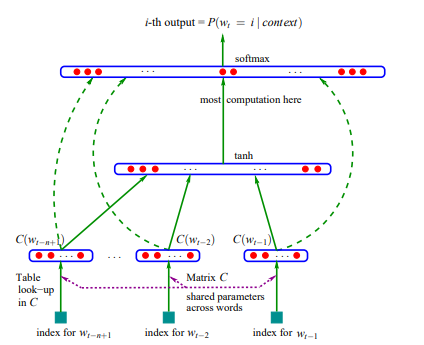

for more information https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * context_length, n_hidden), generator=g) * (5/3)/((n_embd * context_length)**0.5) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [7]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  ## minibatch construct##
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  ## forward pass ##
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

  ## Linear layer ##
  hpre = embcat @ W1 # hidden layer pre-activation                    #NOTE: since BatchNorm follows, the b1 would 'no nothing'

  ## BatchNormalization layer ##
  bnmeani   = hpre.mean(0, keepdim=True)
  bnstdi    = hpre.std (0, keepdim=True)
  hpre      = bngain * (hpre - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running  = 0.999 * bnmean_running    + 0.001 * bnmeani
    bnstd_running   = 0.999 * bnstd_running     + 0.001 * bnstdi

  ## Non-linearity ##
  h     = torch.tanh(hpre) # hidden layer
  logits= h @ W2 + b2 # output layer
  loss  = F.cross_entropy(logits, Yb) # loss function
  
  ## backward pass ##
  for p in parameters:
    p.grad = None
  loss.backward()
  
  ## update ##
  lr = 0.1 if i < 100000 else 0.01 # learning rate 
  for p in parameters:
    p.data += -lr * p.grad

  ## track stats ##
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d} /{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0 / 200000: 3.3239
  10000 / 200000: 2.0322
  20000 / 200000: 2.5675
  30000 / 200000: 2.0125
  40000 / 200000: 2.2446
  50000 / 200000: 1.8897
  60000 / 200000: 2.0785
  70000 / 200000: 2.3681
  80000 / 200000: 2.2918
  90000 / 200000: 2.0238
 100000 / 200000: 2.3673
 110000 / 200000: 2.3132
 120000 / 200000: 1.6414
 130000 / 200000: 1.9311
 140000 / 200000: 2.2231
 150000 / 200000: 2.0027
 160000 / 200000: 2.0997
 170000 / 200000: 2.4949
 180000 / 200000: 2.0199
 190000 / 200000: 2.1707


#### BatchNormalisation

During the training of a model, the parameters (weights) of the early layers will be updated and therefore change the distribution of inputs to the later layers. This is known as internal covariate shift. This problem causes the model to be harder and slower to train, as each layer must adjust to a new domain in every training step.

Batch normalization addresses this issue by normalizing layer inputs across the mini-batch for each training iteration, which stabilizes and accelerates the training process. The normalization is done per feature and independently for each batch.

Mathematically, for a mini-batch $B = {x_1, x_2, ..., x_m}$, the output $y_i$ of the Batch Normalization transformation is calculated as follows:

$$
\mu_{B} = \frac{1}{m} \sum_{i=1}^m x_i
$$

$$
\sigma_B ^2 = \frac{1}{m} \sum_{i=1}^m (x_i - \mu_B)^2
$$

$$
\hat x_i  = \frac{ x_i - \mu_B}{\sqrt{ \sigma_B^2 - \epsilon}}
$$

$$
y_i = \gamma \hat x_i + \beta
$$
Where:

$\mu_B$ is the batch mean,

$\sigma_B^2$ is the batch variance,

$\hat{x_i}$ is the normalized input,

$\epsilon$ is a small constant added for numerical stability,

$\gamma$ and $\beta$ are learnable parameters that allow the layer to learn an arbitrary affine transformation, which helps to preserve the representation power of the network.

The learnable parameters $\gamma$ and $\beta$ are essential because there could be cases where the activations need not be zero-mean/unit-variance. For example, in the case of a layer with ReLU activation, the output is never negative, so a strictly zero mean may not be the optimal choice.

At test time, the normalization is done using the population statistics (mean and variance) instead of batch statistics. These statistics are estimated during training by moving average. Therefore, during training, the model tracks the running average of mean and variance.

The BatchNorm layer in the code above is implemented manually, calculating the mean and standard deviation for each batch of inputs. It applies the normalization and scales and shifts the result using the learned parameters bngain (corresponds to $\gamma$) and bnbias (corresponds to $\beta$).

The running averages of the batch statistics (bnmean_running and bnstd_running) are updated after each batch. At the end of training, these running averages are used to calibrate the BatchNorm layer for evaluation on the validation and test sets.

For more information https://arxiv.org/abs/1502.03167

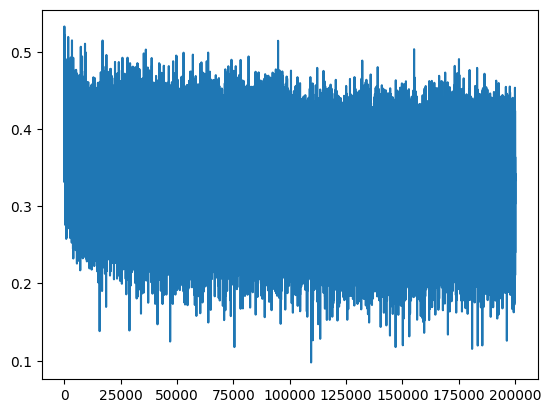

In [8]:
plt.plot(lossi)

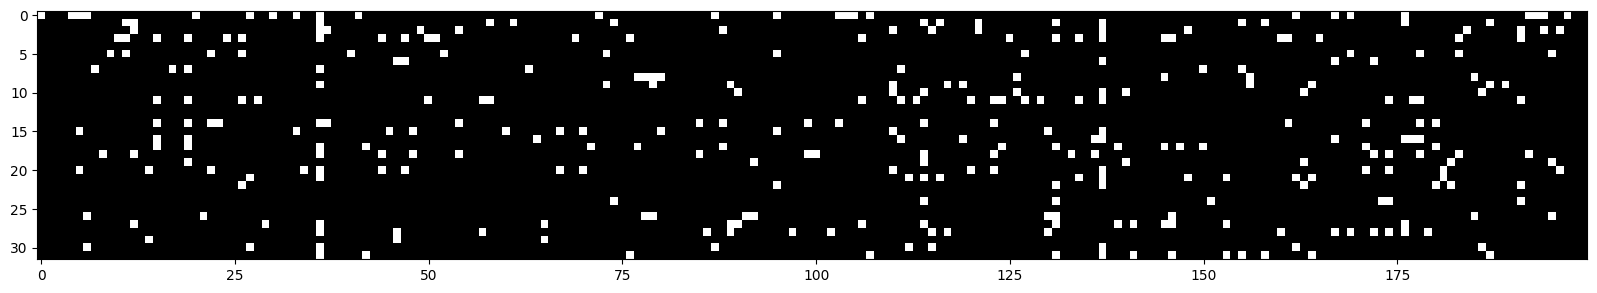

In [9]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() >0.99, cmap='gray',interpolation='nearest')

In [10]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674145221710205
val 2.1056838035583496


The many changes in this model from 'makemore2' is the batch normalization, initalisation of the model.

Problem with initialization: The model was showing a very high loss of 27 on the first (zeroth) iteration which then quickly fell to 1 or 2. This is a clear sign of a problem with the initial configuration.

Expected initial loss: we should generally have an idea of what the initial loss should be. For this particular case, a loss of 3.29 is expected( -log(1/27) since there are 27 possible characters), which is far lower than 27.

Explanation of the problem: The high initial loss was due to the model's initial probability distributions being incorrectly configured. Some characters were assigned a very high probability while others were very low, resulting in the model making very confident, but wrong predictions. Which means the first interations in training will be just unlearning this. 

Solution to the problem: reconfiguring the initialization to ensure the logits are closer to zero. This involves setting the bias (B2) to zero and scaling down the weights (W2) by a factor. Setting weights to exactly zero can be problematic and it's usually better to use small numbers instead.

Impact of the change: After making these changes, the initial loss comes out to be much closer to the expected value and the training loss curve does not show a "hockey stick" appearance. The model starts off good and improves steadily.

Outcome of the fix: The final loss is slightly improved, because the model can spend more iterations actually optimizing the neural network rather than squashing down the weights. The training process is more efficient and the neural net is better trained.

This discussion illustrates the importance of proper model initialization in neural network training and how it can impact the efficiency and final outcome of the training process.

#### But how do we come up with what scales to multiply by:

0.2 and 0.01 that we just basically pulled out of thin air and tweaked until things seemed to work right. This kind of approach might be okay for a simple case like this, but it doesn't scale well to more complex networks, as I've mentioned earlier. The bigger and more complex the network, the harder it is to manually tune these parameters and find a sweet spot where the network performs optimally.

To address this, we can develop a more systematic approach to initialize the weights and biases, using insights from the characteristics of activation functions and the distribution of the input data. Several strategies have been proposed, among them:

Xavier initialization (also known as Glorot initialization): This method is named after Xavier Glorot, one of its creators. It sets the initial weights according to a normal distribution with a mean of zero and a variance of 1/N, where N is the number of inputs to a given neuron. This distribution ensures that the inputs to the activation function are likely to be in the region where the function is most sensitive to changes in its input, maximizing the possibility for learning during the initial stages of training. This method is especially effective for networks using sigmoid or tanh activation functions.

He initialization: Named after Kaiming He, one of its authors, this method is a variation on Xavier initialization that is designed for ReLU and its variants. It sets the initial weights according to a normal distribution with a mean of zero and a variance of 2/N, where N is the number of inputs to a given neuron. This distribution takes into account the fact that half of the output of a ReLU activation function is zero, so it needs a larger variance to ensure that the neurons start in the active phase.

These initialization strategies use the structure of the network itself to set the weights and biases in a way that promotes effective learning right from the start. This removes the need to manually tune these parameters and ensures that the network starts off in a good position to learn from the data. These are just two of the many initialization strategies that exist, and the choice of which to use depends on the specifics of the network being trained, particularly its architecture and activation functions.

Kaiming initialization helps preserve the variance of the activations and the back-propagated gradients throughout the training process, preventing issues such as vanishing/exploding gradients. However, as I mentioned, with the usage of better optimization algorithms, residual connections and normalization layers, the precise initialization has become less critical. 

In practice, it's common to use library implementations of weight initialization methods (such as PyTorch's nn.init.kaiming_normal_), where you just need to specify the 'mode' (whether to consider 'fan-in' or 'fan-out') and the type of non-linearity used. Even if the exact settings may not be as critical as before, understanding these concepts can give you more control over your neural network models and potentially better results.

for more information https://arxiv.org/abs/1502.01852

### what could go wrong if we didnt use such practises:

 If we looked at the values of h in the last model we would get with a histagram:

    plt.hist(h.view(-1).tolist(), 50);
    
we would get: 
    
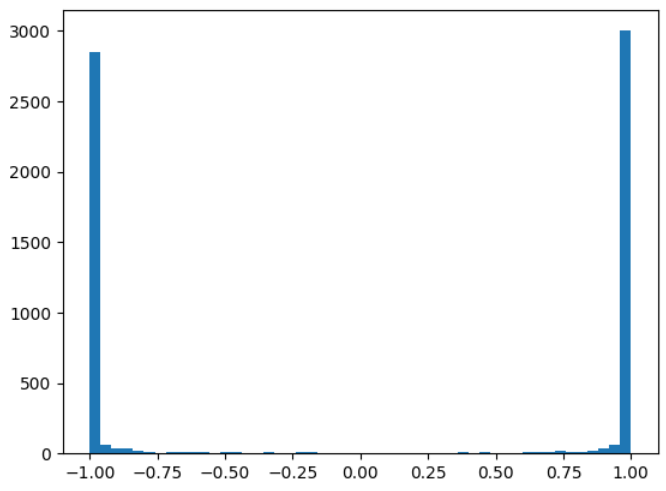

This should be a consern because we are using tanh, which as 1,-1 has grad 0. This can be seen by the formul t=tanh(x), dt/dx = 1-t^2, or by looking at the graph with:

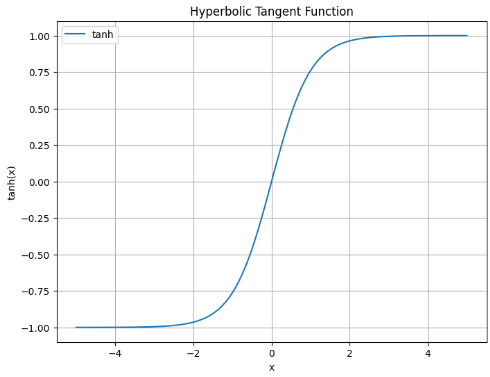

This is a problem since as backpropgation goes through one of these neurons its grad will get 0, so no learning from that value. 

we can make a plot: 

    plt.figure(figsize=(20,10))
    plt.imshow(h.abs() >0.99, cmap='gray',interpolation='nearest')

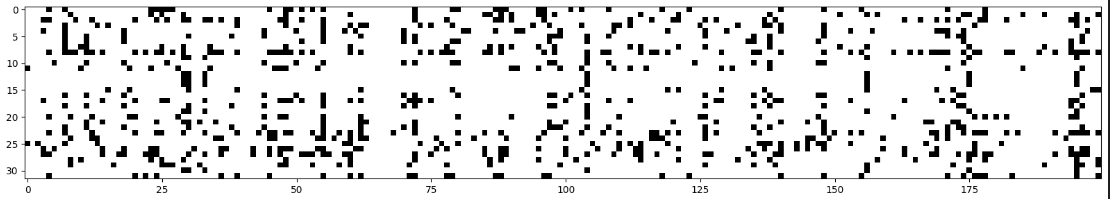

from which white indicates true, if we see a column of just white it means we have a dead neuron and it is not learning anything. As you can see int eh previous model this is indeed the case. To fix this problem similarly we want the inputs in the tanh funciton to be close to 0, the input being C[X] @ W1 + b1, so we can do as we did above and just scale them down. 


### Not we have that understanding lets make the code look a little cleaner, in style that is more common practice.

### Class definitions

In [12]:
class Linear:
    ''' Wx^T + b '''
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn( (fan_in,fan_out), generator=g)/ fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])

Linear class: This class represents a fully connected layer, also known as a linear layer, in the neural network. The __init__ method initializes the weight matrix with a normal distribution, scaled by fan_in's square root for a better start during training. The bias is initialized to zeros if not otherwise specified. The __call__ method defines how this layer processes inputs (it's the forward pass), and the parameters method returns the learnable parameters of this layer.

In [13]:

class BatchNorm1D:
    ''' y = gamma * (x - E[x])/sqrt(Var[x] + eps) + beta '''
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters
        self.gamma = torch.ones(dim)
        self.beta  = torch.zeros(dim)

        # running 'momentum' 
        self.running_mean = torch.zeros(dim)
        self.running_var  = torch.ones(dim)

    def __call__(self,x):
        # forward pass
        if self.training:
            xmean   = x.mean(0, keepdim=True)
            xvar    = x.var (0, keepdim=True)
        else:
            xmean   = self.running_mean
            xvar    = self.running_var
        xhat = (x - xmean) / torch.sqrt( xvar + self.eps )
        self.out = self.gamma * xhat + self.beta

        # updating running mean & var
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var  = (1-self.momentum) * self.running_var  + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

BatchNorm1d class: This class represents a batch normalization layer. The __init__ method initializes the parameters gamma (scale) and beta (shift) which are learnable, and running_mean and running_var which are used to normalize the input during the test phase. The __call__ method calculates the forward pass of the batch normalization layer, which includes calculating the batch mean and variance during the training phase and using the running mean and variance during the test phase. The parameters method returns the learnable parameters of this layer.

### Model and Parameters initialization

In [27]:
#creating the model

dimR = 10 # the dinemsion of the embeding space
hl_size = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproductibiliy 
vocab_size = 27


C = torch.randn((vocab_size, dimR), generator=g)
layers = [
  Linear(dimR * context_length, hl_size,    bias=False), BatchNorm1D(hl_size), tanh(),
  Linear(              hl_size, hl_size,    bias=False), BatchNorm1D(hl_size), tanh(),
  Linear(              hl_size, hl_size,    bias=False), BatchNorm1D(hl_size), tanh(),
  Linear(              hl_size, hl_size,    bias=False), BatchNorm1D(hl_size), tanh(),
  Linear(              hl_size, hl_size,    bias=False), BatchNorm1D(hl_size), tanh(),
  Linear(              hl_size, vocab_size, bias=False), BatchNorm1D(vocab_size),
]


with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1                                                                     
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


Model and Parameters Initialization
In this part, a weight matrix C is created for character embedding vectors. This matrix is randomly initialized and will be learned during the training. Then, several layers are created and added to the layers list to construct the MLP model. The model structure is:

Fully connected layer (Linear -> BatchNorm1d -> Tanh activation),

Repeated five times,

Another fully connected layer (Linear -> BatchNorm1d).

After the layers are created, some initial adjustments are made to the weights, and then the parameters of all layers are collected into a single list.

### Training loop

In [28]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph ????
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 1000:
    # break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870
  10000/ 200000: 2.3578
  20000/ 200000: 2.1043
  30000/ 200000: 1.9646
  40000/ 200000: 2.2144
  50000/ 200000: 2.2266
  60000/ 200000: 1.7339
  70000/ 200000: 2.1748
  80000/ 200000: 2.1895
  90000/ 200000: 1.8281
 100000/ 200000: 2.3635
 110000/ 200000: 2.2592
 120000/ 200000: 2.0967
 130000/ 200000: 1.8977
 140000/ 200000: 1.8304
 150000/ 200000: 1.9419
 160000/ 200000: 1.8676
 170000/ 200000: 1.8346
 180000/ 200000: 2.2491
 190000/ 200000: 2.0141


Training Loop
This part of the code is the training loop. The script uses a batch size of 32 and runs for max_steps iterations. The learning rate is initially set to 0.1 and after 150,000 steps it is reduced to 0.01. The loss function used is cross-entropy loss.

During each iteration, a minibatch of data is sampled, and the model parameters are updated according to the computed gradients. The backward pass is performed with loss.backward(), and then parameters are updated manually.

Statistics, including the loss value, are printed every 10,000 iterations.

layer 2 (      tanh): mean -0.00, std 0.63, saturated: 2.66%
layer 5 (      tanh): mean +0.00, std 0.64, saturated: 2.59%
layer 8 (      tanh): mean -0.01, std 0.65, saturated: 2.22%
layer 11 (      tanh): mean -0.00, std 0.65, saturated: 1.53%
layer 14 (      tanh): mean +0.00, std 0.65, saturated: 2.06%


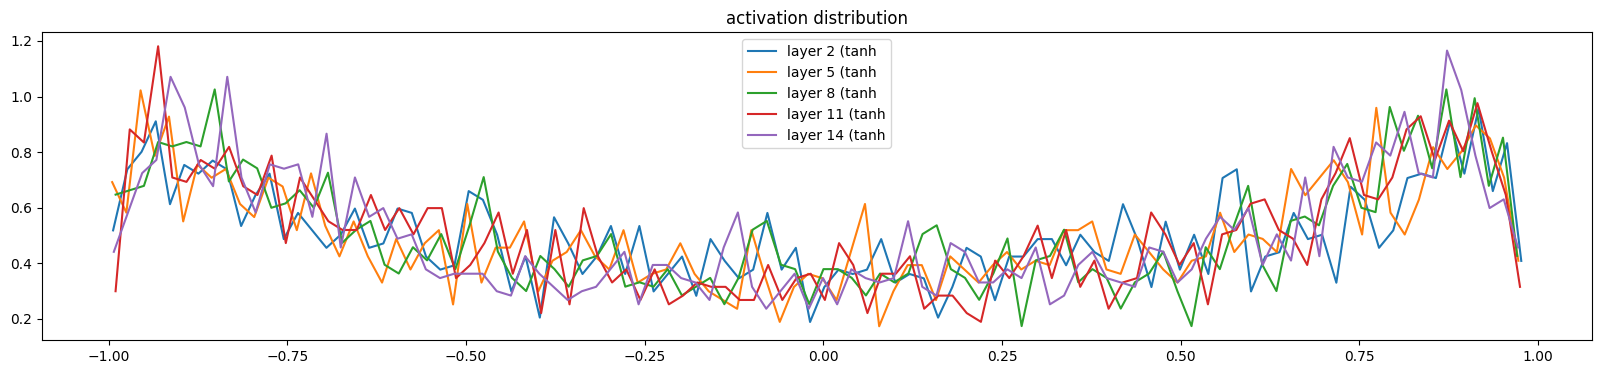

In [16]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution');

Activation Distribution Plot: This plot is useful to understand the distribution of the activation values in the different layers of the network. The activations are the values outputted by the neurons after applying the non-linear activation function, in this case, the Tanh function. By observing the distribution of the activation values, you can gain insights into how the model is transforming the input data in each layer. A well-trained network typically has activations that are well distributed across a range of values. If most activations are saturated near the ends of the Tanh function's range (-1 and +1), this may be indicative of the network not being able to learn complex patterns from the data due to "saturating" or "vanishing" gradients.

layer 2 (      tanh): mean -0.000000, std 3.514123e-03
layer 5 (      tanh): mean +0.000000, std 2.960739e-03
layer 8 (      tanh): mean +0.000000, std 2.739612e-03
layer 11 (      tanh): mean +0.000000, std 2.528343e-03
layer 14 (      tanh): mean -0.000000, std 2.676415e-03


Text(0.5, 1.0, 'gradient distribution')

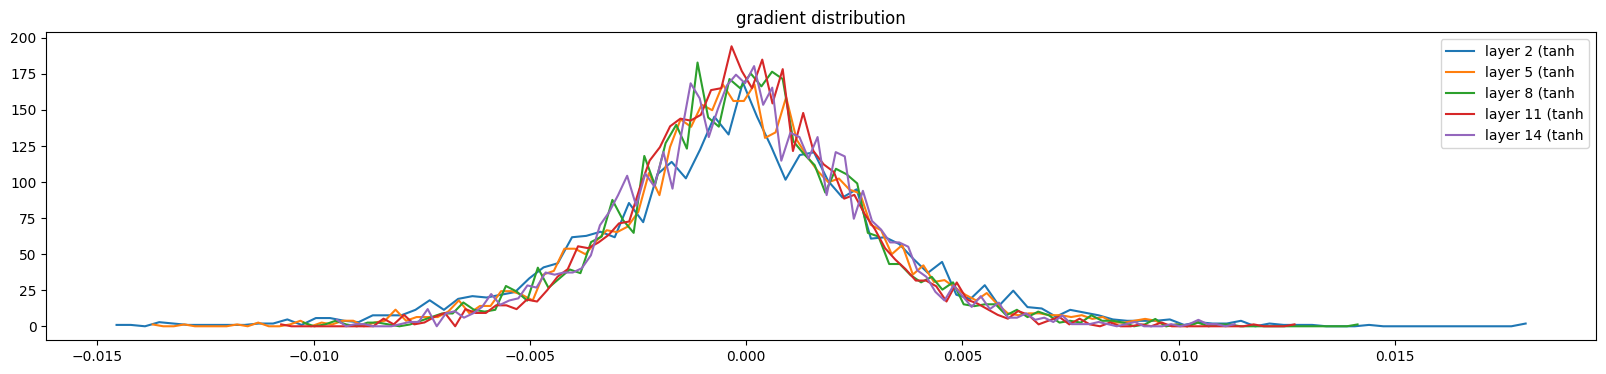

In [17]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

**Backward Pass Gradients:** we can examines the gradients across all layers during the backward pass, highlighting the importance of maintaining stability across layers to prevent gradients from shrinking or exploding.

**Gain Factor and Gradients:** Different settings for the gain factor during initialization can affect the distribution of gradients. Too small a gain (e.g., 0.5) causes activations to shrink, and gradients to expand. Conversely, too large a gain (e.g., 3) results in skewed gradient distributions across layers.

**Impact of Non-linear Activation Functions:** we can removes the tanh layers to study the effect of a purely linear layer stack. In such a scenario, a gain of 1 is ideal to maintain the standard deviation across layers. However, this causes an imbalance between the gradient statistics at the top and bottom layers.

**Need for Non-linear Activation Functions:** Stacking linear layers can maintain a balanced gradient and activation statistics, but it limits the expressiveness of the model since it collapses into a single linear layer in terms of representational power. Non-linearities like tanh make it possible for the network to approximate any arbitrary function.

weight   (27, 10) | mean +0.000000 | std 1.019884e-02 | grad:data ratio 1.018844e-02
weight  (30, 100) | mean +0.000092 | std 8.238419e-03 | grad:data ratio 2.635835e-02
weight (100, 100) | mean +0.000031 | std 7.318100e-03 | grad:data ratio 4.377137e-02
weight (100, 100) | mean -0.000019 | std 6.662019e-03 | grad:data ratio 3.949893e-02
weight (100, 100) | mean -0.000019 | std 5.821510e-03 | grad:data ratio 3.468157e-02
weight (100, 100) | mean +0.000053 | std 5.445291e-03 | grad:data ratio 3.243364e-02
weight  (100, 27) | mean -0.000165 | std 1.046843e-02 | grad:data ratio 6.281257e-02


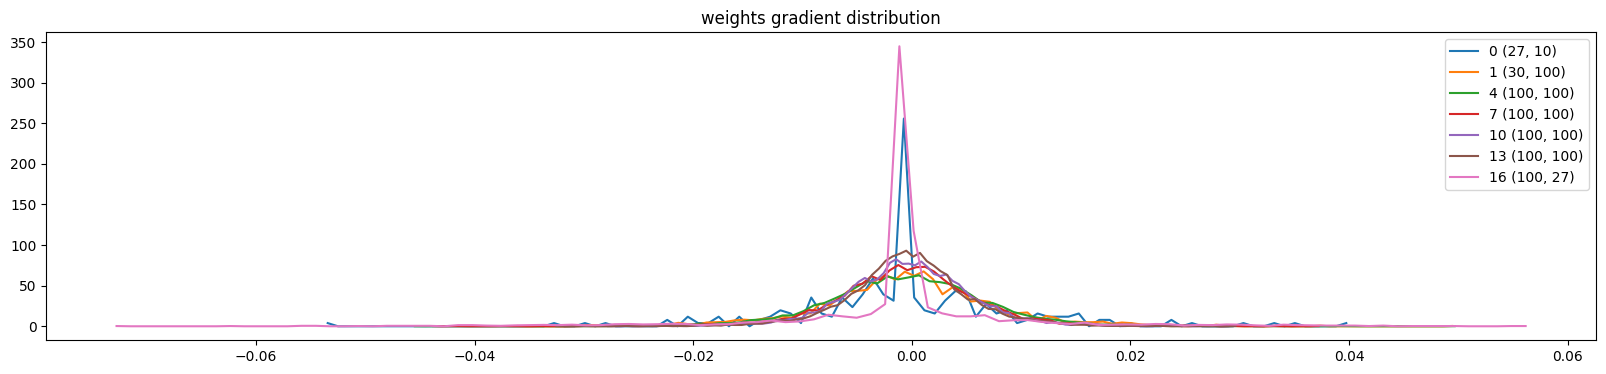

In [25]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

**Parameter, Activation, and Gradient Statistics:** We can then visualizes the statistics of the forward pass activations, the backward pass gradients, and the parameters (weights) of the neural network. we highlight an issue with the last layer, which tends to have larger gradient values compared to other layers, potentially leading to faster training of the final layer compared to others. However, after several training steps, these issues appear to self-correct.

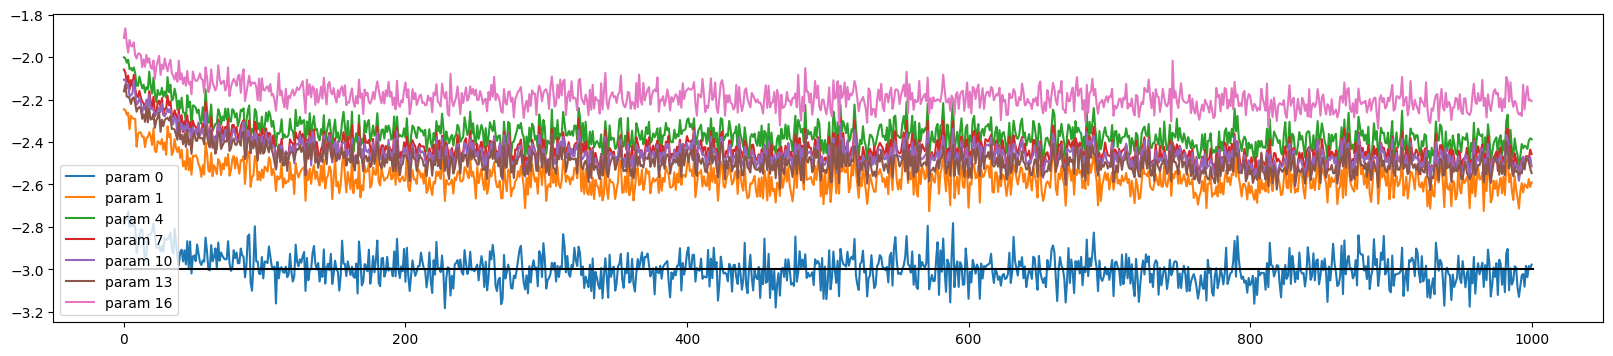

In [19]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.title('update data ratio over steps');

This plot explains another crucial aspect to pay attention to while training neural networks - the update to data ratio. This ratio shows the scale of the updates applied to the neural network's parameters relative to the values already existing in these parameters. Essentially, this provides insight into how rapidly the values in the network are changing.

The update to data ratio is calculated for each training iteration and is logged (base 10) to make the visualization more comprehensible. The plot of these ratios shows how they evolve during the training and how they tend to stabilize. A rough guide for these values is approximately 1e-3, which implies that the changes made at every iteration are no more than about 1/1000 of the magnitudes in those tensors.

However, if these ratios are significantly higher, it suggests that the values are being updated too quickly, which could lead to instability in learning. If these ratios are significantly lower, it might imply that the learning rate is too low and the parameters are not training fast enough.

You can demonstrates this by artificially lowering the learning rate, which shows that the updates are way too small (the size of the update is about 10,000 times smaller in magnitude compared to the size of the numbers in the tensor). This kind of plot can be useful to determine an appropriate learning rate.

On the other hand, if these ratios are misaligned or if the weights initialization is improperly calibrated (for example, without applying the Fan-In initialization), the plots will reveal this by showing saturated neurons, skewed gradient and weight histograms, and discrepancies in the speed of learning across layers.

So, these plots can be extremely beneficial in revealing any miscalibrations in the model and alerting you to address them.

In [20]:
torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = { 'train': (Xtr,   Ytr),
          'val'  : (Xdev, Ydev),
          'test' : (Xte,   Yte),
      }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.3850746154785156
val 2.383229970932007


Once you have debugged the model comment out the break in the training. Training the model then finaly see hwot he model preforms of the test set.

In [ ]:
# after training the model
# split_loss('test')

**Batch Normalization:** As we've tackled issues with deep neural network training, we have introduced Batch Normalization, a technique designed to address these challenges. This process standardizes the input layer by layer, helping manage problems related to high activation outputs or gradients that become excessively small or large. What's impressive about Batch Normalization is that it makes our model more robust, reducing the necessity for highly precise gain calibration.

**Integrating BatchNorm into our model:** In our discussions, we've identified various positions where BatchNorm can be seamlessly integrated: typically after the linear layer but before the non-linearity, or even after the non-linearity. It's also feasible to place it after the last linear layer, right before the loss function. Through our practical demonstrations, we've seen that BatchNorm can enhance our model's robustness to changes in the gain of the linear layers.

**Model Robustness:** With BatchNorm incorporated, we've observed how the activations, gradients, parameters, and updates remain robust and are relatively unaffected by the gain of the linear layers. However, bear in mind that the scale of updates on parameters may vary, implying that if we change the scale of the activations entering the BatchNorm significantly, there might be a need to fine-tune the learning rate.

**Visualizations & Diagnostics:** We've shared a series of diagnostic tools to help assess if your network is in a healthy state. These include observing the statistics of activation of the forward pass, gradient activations of the backward pass, and scrutinizing the updates as part of stochastic gradient ascent.

**Layer Abstraction:** Our discussions have highlighted the modularity of PyTorch, demonstrating how layers can be abstracted and stacked akin to Lego building blocks. The API we developed in this session is fully compatible with PyTorch, offering the convenience of integrating these layers directly with PyTorch.

**Current limitations:** Despite the advancements we've made with BatchNorm, we still encounter challenges in areas such as initialization and backpropagation, which continue to be active and intriguing subjects in research. It's also noteworthy that the network developed in our current session didn't achieve superior performance due to the context length bottleneck. Therefore, advanced architectures such as Recurrent Neural Networks or Transformers might need to be considered for further improvements.

In [29]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * context_length # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0